Exploring a dataset with information about patients. 
Consider next 8 features to predict the mortality rate:
1. Age
2. CHF KiLLip
3. HBR (b)
4. Systolic AP(b)
5. Creatine in blood
6. EF Percentage
7. White blood cells count
8. Glucose

# 1. Import required libraries and load the dataset

In [2]:
import numpy as np
import pandas as pd
from IPython.display import display

In [3]:
# Load dataset
ready_data = pd.read_csv('./import/dataset_prepared.csv')

# 2. Split the dataset into features and target.

In [4]:
X = ready_data.drop('Class', axis=1)
y = ready_data['Class']

We want to consider hyper parameters, so we will use three different random_state parameters. 

In [5]:
random_states = [0, 25, 42]

## 3. GXBoost

In [8]:
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report
import shap


feature_names = ["Age", "CHF KiLLip", "HBR (b)", "Systolic AP(b)", "Creatinine in blood", "EF Percentage", "White blood cells count", "Glucose"]

feature_importances = pd.DataFrame(index=feature_names)
shap_values_list = []

for random_state in random_states:
    # Split the data
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state, stratify=y)

    # Define model
    model = xgb.XGBClassifier(eval_metric='logloss', random_state=random_state)

    # Define hyperparameters for grid search
    hyperparameter_grid = {
        'n_estimators': [10, 50, 100, 200], 
        'max_depth': [None, 2, 5, 10], 
        'learning_rate': [0.1, 0.01, 0.001],
        'scale_pos_weight': [1, 10, 30, 50, 75, 99, 100, 1000]
        }

    # Define grid search
    grid_cv = GridSearchCV(estimator=model, 
                           param_grid=hyperparameter_grid,
                           cv=skf,
                           scoring='f1_macro')

    # Execute grid search
    grid_cv.fit(X_train, y_train)

    # Display best parameters
    print(grid_cv.best_params_)

    # Retrain the model with the best parameters
    model = xgb.XGBClassifier(eval_metric='logloss',
                              random_state=random_state, 
                              n_estimators=grid_cv.best_params_['n_estimators'], 
                              max_depth=grid_cv.best_params_['max_depth'], 
                              learning_rate=grid_cv.best_params_['learning_rate'],
                              scale_pos_weight=grid_cv.best_params_['scale_pos_weight'],
                              n_jobs=-1)

    model.fit(X_train, y_train)

    # Predict probabilities
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    # Predict classes
    y_pred = model.predict(X_test)
   
    # Print ROC-AUC, confusion matrix, and classification report
    print(f"========== {random_state=} ==========")
    print('ROC-AUC:', roc_auc_score(y_test, y_pred_proba))
    print('Classification report:\n', classification_report(y_test, y_pred))
    print('Confusion matrix:\n', confusion_matrix(y_test, y_pred))

    # Calculate SHAP values
    explainer = shap.Explainer(model, X_train)
    shap_values = explainer(X_test)

    shap_values_list.append(shap_values.values)
    feature_importances[random_state] = model.feature_importances_
    feature_importances[str(random_state)+"_shap"] = np.mean(np.abs(shap_values.values), axis=0)

# Calculate mean feature importances and SHAP values
feature_importances['mean_importance'] = feature_importances[random_states].mean(axis=1)
feature_importances['mean_shap'] = feature_importances[[str(state) + "_shap" for state in random_states]].mean(axis=1)


{'learning_rate': 0.1, 'max_depth': None, 'n_estimators': 200, 'scale_pos_weight': 50}
========== random_state=0 ==========
ROC-AUC: 0.8401826484018265
Classification report:
               precision    recall  f1-score   support

           0       0.98      0.98      0.98       584
           1       0.38      0.38      0.38        21

    accuracy                           0.96       605
   macro avg       0.68      0.68      0.68       605
weighted avg       0.96      0.96      0.96       605

Confusion matrix:
 [[571  13]
 [ 13   8]]
{'learning_rate': 0.1, 'max_depth': None, 'n_estimators': 200, 'scale_pos_weight': 50}
========== random_state=25 ==========
ROC-AUC: 0.7862035225048924
Classification report:
               precision    recall  f1-score   support

           0       0.97      0.99      0.98       584
           1       0.46      0.29      0.35        21

    accuracy                           0.96       605
   macro avg       0.72      0.64      0.67       605
weight

In [14]:
feature_importances

,0,0_shap,25,25_shap,42,42_shap,mean_importance,mean_shap
Age,0.060642,0.390202,0.064743,0.337453,0.056664,0.133612,0.060683,0.287089
CHF KiLLip,0.190888,0.325040,0.153386,0.361887,0.189681,0.159345,0.177985,0.282091
HBR (b),0.149509,0.557662,0.157516,0.490961,0.103652,0.323794,0.136892,0.457472
Systolic AP(b),0.080578,0.322818,0.072071,0.248876,0.099426,0.048132,0.084025,0.206609
Creatinine in blood,0.109063,0.473674,0.098437,0.380510,0.157586,0.189075,0.121695,0.347753
EF Percentage,0.255294,0.939358,0.283111,1.027668,0.207054,0.508691,0.248486,0.825239
White blood cells count,0.091641,0.641856,0.093826,0.729278,0.073902,0.180196,0.086457,0.517110
Glucose,0.062385,0.623857,0.076910,0.702448,0.112034,0.212806,0.083777,0.513037


In [13]:
import matplotlib.pyplot as plt

def plot_weights (feature_importances, column1, column2, label1, label2, title, num_digits=3):
    barWidth = 0.25

    r1 = np.arange(len(feature_importances[column1]))
    r2 = [x + barWidth for x in r1]

    plt.figure(figsize=(13, 6))
    bars1 = plt.barh(r1, feature_importances[column1], color='blue', height=barWidth, edgecolor='grey', label=label1)
    bars2 = plt.barh(r2, feature_importances[column2], color='orange', height=barWidth, edgecolor='grey', label=label2)

    plt.yticks([r + barWidth for r in range(len(feature_importances[column1]))], feature_importances.index)

    def add_values(bars):
        for bar in bars:
            width = bar.get_width()
            plt.text(width,               
                    bar.get_y() + bar.get_height() / 2.2 ,  
                    f"{width :.{num_digits}f}",  
                    ha='left', va='center')  


    add_values(bars1)
    add_values(bars2)

    plt.xlabel('Score')
    plt.ylabel('Feature')
    plt.title(title)
    plt.legend(loc='lower right')
    plt.show()

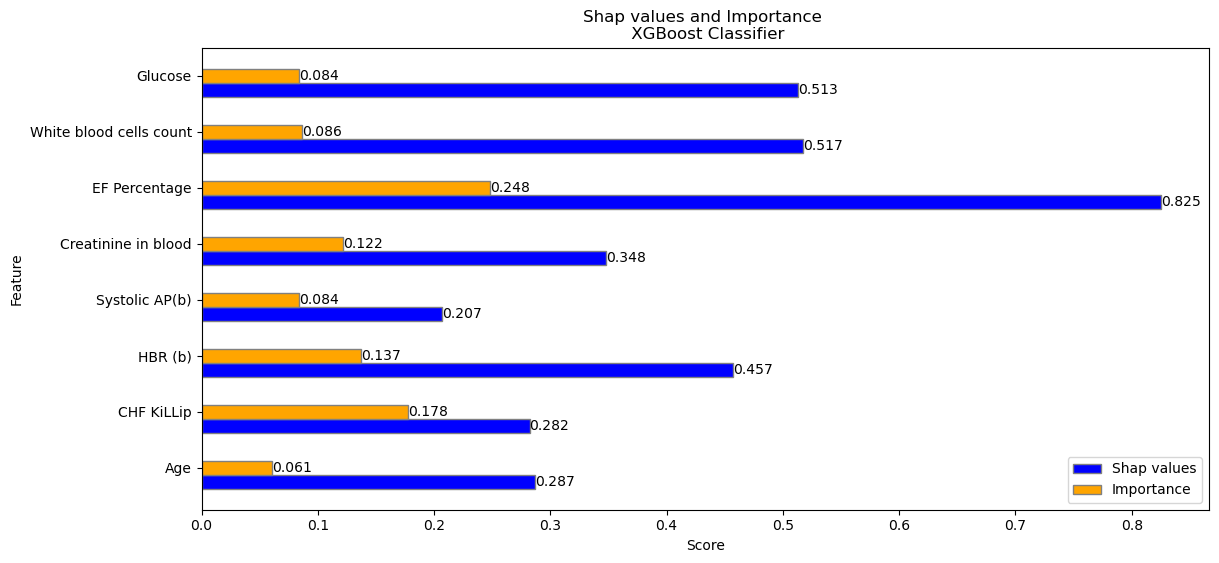

In [15]:
plot_weights(feature_importances, 
             column1='mean_shap', 
             column2='mean_importance', 
             label1='Shap values', 
             label2='Importance', 
             title='Shap values and Importance \n XGBoost Classifier',
             num_digits=3)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


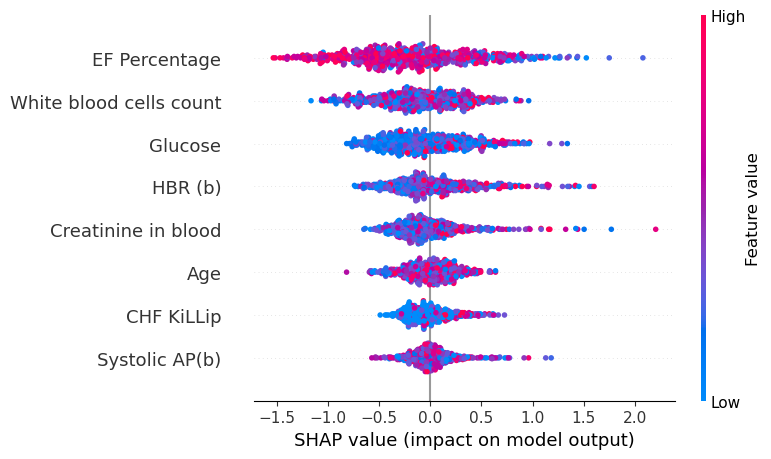

In [16]:
mean_shap_values = np.mean(shap_values_list, axis=0)
shap.summary_plot(mean_shap_values, X_test, feature_names=feature_names)